<a href="https://colab.research.google.com/github/Dovermore/COMP5046-ass1/blob/master/zhua9812_COMP5046_Ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Space for my pyautogui script to keep colab alive
# Hello world!
# Hello world!
# Hello world!
# Hello 


# COMP5046 Assignment 1
*Make sure you change the file name with your unikey.*

# Readme
*If there is something to be noted for the user, please mention here.* 

*If you are planning to implement a program with Object Oriented Programming style*

***Visualising the comparison of different results is a good way to justify your decision.***

# 1 - Data Preprocessing

## 1.1. Download Dataset

In [0]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1vF3FqgBC1Y-RPefeVmY8zetdZG1jmHzT'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_train.csv')

id = '1XhaV8YMuQeSwozQww8PeyiWMJfia13G6'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_test.csv')

import pandas as pd
df_train = pd.read_csv("imdb_train.csv")
df_test = pd.read_csv("imdb_test.csv")

reviews_train = df_train['review'].tolist()
sentiments_train = df_train['sentiment'].tolist()
reviews_test = df_test['review'].tolist()
sentiments_test = df_test['sentiment'].tolist()

print("Training set number:",len(reviews_train))
print("Testing set number:",len(reviews_test))

Training set number: 25000
Testing set number: 25000


In [0]:
# install some other necessary libraries
# Expand contractions
!pip install contractions
!pip install feather-format

# Setup saving and loading
from google.colab import files, drive
from pathlib import Path
drive.mount('/content/drive')
drive_path = Path("/content/drive/My Drive/COMP5046-assignment1/")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2. Preprocess data

*You are required to describe which data preprocessing techniques were conducted with justification of your decision. *

In [0]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin

import copy
import re
from bs4 import BeautifulSoup
import contractions

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
from nltk import FreqDist

# These words affect the reasoning of the sentence
negative_words = set(["no", "nor", "not", "but"])
stop_words = set(sw.words()) - negative_words
# Lemmatise the words
lemmatizer = WordNetLemmatizer()


def remove_punctuation(x):
    """
    Remove all non white space or word character in function x
    :param x: The sentence to process
    :return: str with all non white space or word character removed
    """
    x = re.sub(r'[^\w\s]',' ',x)
    return x

def convert_numbers(x):
    """
    Convert numbers to number token
    :param x: The sentence to process
    :return: str with all numbers converted accordingly
    """
    # Replace digit of different length with corresponding token
    x = re.sub(r'[0-9]{5,}', '<4+NUM>', x)
    x = re.sub(r'[0-9]{4}', '<4NUM>', x)
    x = re.sub(r'[0-9]{3}', '<3NUM>', x)
    x = re.sub(r'[0-9]{2}', '<2NUM>', x)
    # Remove fraction symbols (and other other category symbol)
    x = re.sub(r'[½¾]', '', x)
    return x

def preprocess_texts(X, rm_htmltag=True, expand_contraction=True, to_lower=True, rm_punctuation=True,
                     cv_numbers=True, stop_words=stop_words, lemmatize=True, min_count=5):
    """
    Preprocess texts with the specified preprocessing procedures
    :param X: A list of texts to be processed
    :param rm_htmltag: If html tags should be removed
    :param expand_contraction: If contraction should be expanded
    :param to_lower: If cases should be converted to lower case
    :param rm_punctuation: If punctuation should be removed
    :param lemmatize: If tokens should be lemmatized
    :return: list[list[processed token]]
    """
    if rm_htmltag:
        # Use beautiful soup to remove html tags if any
        X = [BeautifulSoup(s).get_text() for s in X]

    if expand_contraction:
        # expand contactions (english only) to normalise text (this before lower case because this will give uppercase)
        X = [contractions.fix(s) for s in X]

    if to_lower:
        # Case folding is necessary to reduce the unique words and removing some irregular case formulation for words.
        # Though this may cause the loss of some information (for instance, all CAPPED words have strong emotion),
        # it is generally beneficial to smooth the occurances of words
        X = [s.lower() for s in X]

    if rm_punctuation:
        # Remove punctuations is necessary for almost the same reason as the case folding. Here because each tweet is self
        # contained, no need to add end of sentence token.
        X = [remove_punctuation(s) for s in X]

    if cv_numbers:
        X = [convert_numbers(s) for s in X]

    # Tokenization is necessary to extract each individual words instead of feeding in raw sentences.
    X = [word_tokenize(sent) for sent in X]

    # Stop words are NOT removed (yet) for they sometimes affect the sentiment by a lot (like word not, wouldn't)
    # If I can get better list and spend more time understanding the data then I will remove them
    if stop_words is not False and len(stop_words):
        X = [[w for w in tokens if not w in stop_words] for tokens in X]

    if lemmatize:
        # Lemmatise tokens to reduce the number of unique words, and make the training process easier by reducing the labels
        X = [[lemmatizer.lemmatize(w) for w in tokens] for tokens in X]
    
    if min_count > 1:
        all_tokens = [w for tokens in X for w in tokens]
        token_set = set(k for k, v in FreqDist(all_tokens).items() if v >= min_count)
        X = [[w for w in tokens if w in token_set] for tokens in X]

    return X


class TextPreprocessTransformer(TransformerMixin):
    """
    Simple transformer class to wrap the previous transformation
    """
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None):
        return preprocess_texts(X, **self.kwargs)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Import necessary libraries
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Observe raw distribution

In [0]:
raw_tokens = preprocess_texts(reviews_train, rm_htmltag=False, expand_contraction=False, 
                              to_lower=False, rm_punctuation=False, cv_numbers=False,
                              stop_words=False, lemmatize=False, min_count=1)
raw_tokens = [w for tokens in raw_tokens for w in tokens]
raw_fd = FreqDist(raw_tokens)
sns.distplot(list(raw_fd.values()), bins=10, norm_hist=False)
len(list(raw_fd.keys()))

#### Observe processed Distribution

25350

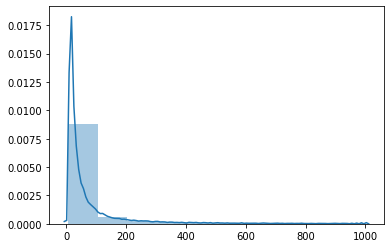

In [0]:
processed_tokens = preprocess_texts(reviews_train, min_count=5)
processed_tokens = [w for tokens in processed_tokens for w in tokens]
processed_fd = FreqDist(processed_tokens)
sns.distplot([v for v in processed_fd.values() if v < 1000], bins=10, norm_hist=False)
len(list(processed_fd.keys()))

In [0]:
tpt = TextPreprocessTransformer()
tokens_train = tpt.fit_transform(reviews_train)
tokens_test = tpt.transform(reviews_test)

total_len_train = 0
for tokens in tokens_train:
    total_len_train += len(tokens)

total_len_test = 0
for tokens in tokens_test:
    total_len_test += len(tokens)

print(tokens_train[:2])
print(tokens_test[:2])

print(total_len_train)
print(total_len_test)

[['enjoyed', 'movie', 'not', 'seen', 'andy', 'griffith', 'age', 'felt', 'fit', 'role', 'perfectly', 'associated', 'comedy', 'but', 'pleased', 'see', 'versatile', 'not', 'troubled', 'dotty', 'anxiety', 'disorder', 'may', 'not', 'verbatim', 'psychiatric', 'textbook', 'zillion', 'whatever', 'phobia', 'neurosis', 'broad', 'variety', 'form', 'clearly', 'sensitive', 'extra', 'sensory', 'power', 'understood', 'local', 'indian', 'but', 'not', 'anglos', 'not', 'surprising', 'character', 'vulnerable', 'eccentric', 'although', 'taken', 'light', 'family', 'movie', 'actually', 'sophisticated', 'seems', 'twist', 'came', 'pleasant', 'surprise', 'tied', 'preceding', 'action', 'together', 'bundle', 'fun', 'contemplate', 'possibility', 'spiritual', 'guidance'], ['whole', 'not', 'even', 'close', 'sum', 'part', 'no', 'problem', 'film', 'feature', 'line', 'creative', 'director', 'time', 'really', 'famous', 'name', 'cast', 'segment', 'devised', 'around', 'theme', 'love', 'paris', 'but', 'resemblance', 'end'

In [0]:
label_encoder = LabelEncoder()
label_encoder.fit(sorted(list(set(sentiments_train))))
label_train = label_encoder.transform(sentiments_train)
label_test = label_encoder.transform(sentiments_test)
print(label_train[:50])
print(label_test[:50])

[1 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0
 0 0 0 0 1 1 0 0 1 0 0 1 1]
[1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0
 1 1 1 0 0 0 0 1 0 0 0 1 0]


In [0]:
import pandas as pd

def check_create_parent(path: Path):
    if not (path.parent.exists() and path.parent.is_dir()):
        path.parent.mkdir(parents=True, exist_ok=False)

# Create df to store the data
def save_feather(tokens, labels, sentiments, path):
    df = pd.DataFrame(columns=["tokens", "labels", "sentiments"])
    df["tokens"] = [" ".join(t) for t in tokens]
    df["labels"] = labels 
    df["sentiments"] = sentiments
    check_create_parent(path)
    df.to_feather(path)

def load_feather(path):
    df = pd.read_feather(path)
    tokens = df["tokens"]
    labels = df["labels"]
    sentiments = df["sentiments"]
    tokens = [t.split(" ") for t in tokens]
    return tokens, labels, sentiments


train_path = drive_path/"data"/"train.feather"
test_path = drive_path/"data"/"test.feather"

In [0]:
# Save processed data
save_feather(tokens_train, label_train, sentiments_train, train_path)
save_feather(tokens_test, label_test, sentiments_test, test_path)

NameError: ignored

In [0]:
# Load from processed data
tokens_train, label_train, sentiments_train = load_feather(train_path)
tokens_test, label_test, sentiments_test = load_feather(test_path)

# 2 - Model Implementation

## 2.1. Word Embeddings

*You are required to describe which model was implemented (i.e. Word2Vec with CBOW, FastText with SkipGram, etc.) with justification of your decision *

### 2.1.1. Data Preprocessing for Word Embeddings

*You are required to describe which preprocessing techniques were used with justification of your decision.*

**Important**: If you are going to use the code from lab3 word2vec preprocessing. Please note that `word_list = list(set(word_list)) ` has randomness. So to make sure the word_list is the same every time you run it, you can put `word_list.sort()` after that line of code.

In [0]:
from sklearn.base import TransformerMixin
import pandas as pd
import numpy as np
from random import shuffle
# np.random.seed(0)

# Token -> Ordinal
class VocabCardinalTransformer(TransformerMixin):
    """
    Base transformer handling vocabulary related tasks by fitting a vocabulary
    """
    def __init__(self):
        self.token_list = []
        self.token_dict = {}

    def fit(self, X, y=None, **fit_params):
        """
        Fit this transformer with training data to obtain vocabulary
        :param X: Training data to be fitted
        :param y: Ignored
        :param refit: Specifies if this fit should be a refit (reinitialise vocab list) or build upon previous vocab list
        :return: itself for chaining
        """
        refit = fit_params.get("refit", False)
        token_set = set()
        for tokens in X:
            token_set |= set(tokens)
        if refit:
            self.token_list = sorted(token_set)
        else:
            token_set -= set(self.token_list)
            self.token_list += sorted(token_set)
        self.token_dict = {w: i for i, w in enumerate(self.token_list)}
        return self

    def transform(self, X, y=None):
        mapped_tokens = []
        for tokens in X:
            mapped_tokens.append([self.token_dict[t] for t in tokens if t in self.token_dict])
        return mapped_tokens


# First define a dataset generator
class SkipGramTransformer(TransformerMixin):
    """
    Transformer class to convert raw list of list of tokens to data to be trained for skipgram model
    """
    def __init__(self, window=10, drop_prob=0):
        """
        Init this transformer with a given window size for sampling skip grams
        :param window: The window size for sampling. Note this is the size of one side,
            the total number of context sampled is 2 * window
        :param drop_prob: Probability dropping a target word, used to increase the stochasticity
            and mixing the training data better
        """
        self.window = window
        self.drop_prob = drop_prob

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None):
        """
        Transforms a given dataset (list of list of tokens) to negative gram data (target, context) pair
        :param X: The input data
        :param y: Ignored
        :return: One array of targets and one array of contexts
        """
        skip_grams = []
        for tokens in X:
            for i in range(len(tokens)):
                target = tokens[i]
                if np.random.uniform() < self.drop_prob: continue
                for k in range(max(i - self.window, 0), min(i + self.window + 1, len(tokens))):
                    if k == i: continue
                    context = tokens[k]
                    skip_grams.append([target, context])
        X, y = list(zip(*skip_grams))
        return np.array(X), np.array(y)

    def generator(self, X, batch_size=1024): 
        """ 
        Generates a generator for transforming a given dataset (list of list of tokens) to negative 
        gram data (target, context) pair. The generated generator will generate an array of 
        target words and array of context words both of shape (batch_size, ). 
        This is needed because the previous way of generating will exceed the memory 
        capacity 
        :param X: The input data 
        :param y: Ignored 
        :return: A generator whose __next__ output the following data:
            Array of targets, array of contexts, flag specifying if this is the end of a epoch 
        """ 
        # TODO optimise the running time of this
        X = copy.deepcopy(X)
        skip_gram_pool = np.zeros((0, 2), dtype=int)
        idx = 0
        while True:
            # While the pool is not filled and the data is not cycled to the end, populate pool
            # and advance the idx
            while skip_gram_pool.shape[0] < batch_size * 3 and idx < len(X):
                tokens = X[idx]
                skip_grams = []
                for i in range(len(tokens)):
                    target = tokens[i]
                    if np.random.uniform() < self.drop_prob: continue
                    for k in range(max(i - self.window, 0), min(i + self.window + 1, len(tokens))):
                        if k == i: continue
                        context = tokens[k]
                        skip_grams.append([target, context])
                if len(skip_grams):
                    skip_gram_pool = np.concatenate([skip_gram_pool, skip_grams], axis=0)
                # Advance idx
                idx += 1

            # Batch sampling of index
            batch_idx = np.random.choice(skip_gram_pool.shape[0], 
                                         size=min(batch_size, skip_gram_pool.shape[0]), 
                                         replace=False)
            # Epoch end if the data has been cycled through and pool will be empty
            end_epoch = (idx >= len(X) and batch_size >= skip_gram_pool.shape[0])
            # print(end_epoch, skip_gram_pool.shape[0])
            yield skip_gram_pool[batch_idx, 0], skip_gram_pool[batch_idx, 1].reshape(-1), end_epoch
            # If this epoch ended, start a new cycle
            if end_epoch:
                idx %= len(X)
                shuffle(X)
            skip_gram_pool = np.delete(skip_gram_pool, batch_idx, axis=0)

    def generator2(self, X, batch_size=1024): 
        """ 
        Generates a generator for transforming a given dataset (list of list of tokens) to negative 
        gram data (target, context) pair. The generated generator will generate an array of 
        target words and array of context words both of shape (batch_size, ). 
        This is needed because the previous way of generating will exceed the memory 
        capacity 
        :param X: The input data 
        :param y: Ignored 
        :return: A generator whose __next__ output the following data:
            Array of targets, array of contexts, flag specifying if this is the end of a epoch 
        """ 
        X = deepcopy(X)
        shuffle(X)
        skip_gram_pool = np.zeros((0, 2), dtype=int)
        idx = 0
        while True:
            # While the pool is not filled and the data is not cycled to the end, populate pool
            # and advance the idx
            while skip_gram_pool.shape[0] < batch_size and idx < len(X):
                tokens = X[idx]
                skip_grams = []
                for i in range(len(tokens)):
                    target = tokens[i]
                    if np.random.uniform() < self.drop_prob: continue
                    for k in range(max(i - self.window, 0), min(i + self.window + 1, len(tokens))):
                        if k == i: continue
                        context = tokens[k]
                        skip_grams.append([target, context])
                if len(skip_grams):
                    skip_gram_pool = np.concatenate([skip_gram_pool, skip_grams], axis=0)
                # Advance idx
                idx += 1

            # Epoch end if the data has been cycled through and pool will be empty
            end_epoch = (idx >= len(X) and batch_size >= skip_gram_pool.shape[0])
            # print(end_epoch, skip_gram_pool.shape[0])
            yield skip_gram_pool[:batch_size, 0], skip_gram_pool[:batch_size, 1].reshape(-1), end_epoch
            # If this epoch ended, start a new cycle
            if end_epoch:
                idx %= len(X)
                shuffle(X)
            skip_gram_pool = skip_gram_pool[batch_size:]


class VocabSkipGramTransformer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.vocab_transformer = VocabCardinalTransformer()
        self.skip_gram_transformer = SkipGramTransformer(*args, **kwargs)
    
    def fit(self, X, y=None, **fit_params):
        self.vocab_transformer.fit(X, y, **fit_params)
        return self

    def transform(self, X, y=None):
        return self.skip_gram_transformer.transform(self.vocab_transformer.transform(X))

    def generator(self, X, batch_size=1024):
        return (self.skip_gram_transformer
                .generator(self.vocab_transformer.transform(X), 
                           batch_size=batch_size))
    
    def get_token_list(self):
        return self.vocab_transformer.token_list

In [0]:
# Test
sgt = VocabSkipGramTransformer(drop_prob=0)
test_data = np.array(range(10)).reshape(5, 2).tolist()
sgt.fit(test_data)
i = 0
for i, (a, b, c) in enumerate(sgt.generator(test_data, 2)):
    print(i, a, b, c)
    if i > 20:
        break
print(sgt.get_token_list())

0 [2 0] [3 1] False
1 [3 7] [2 6] False
2 [4 6] [5 7] False
3 [9 8] [8 9] False
4 [5 1] [4 0] True
5 [6 9] [7 8] False
6 [3 7] [2 6] False
7 [5 1] [4 0] False
8 [4 0] [5 1] False
9 [2 8] [3 9] True
10 [4 7] [5 6] False
11 [0 6] [1 7] False
12 [3 1] [2 0] False
13 [8 2] [9 3] False
14 [5 9] [4 8] True
15 [1 9] [0 8] False
16 [7 6] [6 7] False
17 [5 3] [4 2] False
18 [2 8] [3 9] False
19 [4 0] [5 1] True
20 [2 0] [3 1] False
21 [7 1] [6 0] False
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [0]:
# Profile time
sgt = VocabSkipGramTransformer(drop_prob=0)
sgt.fit(tokens_train)
datagen = sgt.generator(tokens_train)
%timeit -n 1000 next(datagen)

1000 loops, best of 3: 1.15 ms per loop


### 2.1.2. Build Word Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [0]:
import os
import time
import math
import torch
# torch.manual_seed(0)
from torch import nn
from torch.utils import data
from torch.optim import Adam
from datetime import datetime
from copy import deepcopy

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("device is ", device)


# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def get_net_dict(net):
    return deepcopy(net.state_dict())


class FileNameGenerator:
    def __init__(self, prefix, postfix=".pt"):
        self.prefix = prefix
        self.postfix = postfix

    def _gen_fname(self, offset=0):
        i = 0
        path = self._format_path(i)
        while path.exists():
            i += 1
            path = self._format_path(i)
        if i + offset < 0:
            return None
        return self._format_path(i + offset)
    
    def read_fname(self, serial=None):
        if serial is None:
            return self._gen_fname(offset=-1)
        return self._format_path(serial)

    def write_fname(self, serial=None):
        if serial is None:
            return self._gen_fname()
        return self._format_path(serial)
    
    def _format_path(self, serial):
        return Path("%s%d%s" % (self.prefix, serial, self.postfix))



# TODO refactor this class
class BaseModel:
    def __init__(self, net:nn.Module, optimizer, ckpt_fname_gen:FileNameGenerator, device=device):
        super().__init__()
        # Store model
        self.net = net 
        # store optimizer
        self.optimizer = optimizer
        # ckpt name generator
        self.ckpt_fname_gen = ckpt_fname_gen
        # loss (should be overridden if needed)
        self.loss = nn.CrossEntropyLoss()
        # device this is trained on
        self.device = device
        # State of the model
        self.training = True
        self.best_net_dict = None
        if self.net is not None:
            # Send to the device
            self.net.to(self.device)
            self.best_net_dict = None
            self.best_net_dict = get_net_dict(self.net)

    def train_step(self, X_batch, y_batch):
        # zero the parameter gradients
        self.optimizer.zero_grad()
    
        # forward + backward + optimize
        outputs = self.net.forward(X_batch)
        loss = self.loss(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        #print("--------------------")
        #print(outputs.size())
        #print(y_batch.size())
        return outputs, loss

    def train(self, data, epochs, batch_size=1024, data_gen_dict={}, batch_display_interval=10000, 
                    epoch_display_interval=100, ckpt_interval=1):
        if batch_display_interval <= 0:
            batch_display_interval = 1000000000
        if epoch_display_interval <= 0:
            epoch_display_interval = 1000000000
        if ckpt_interval <= 0:
            ckpt_interval = 1000000000

        self.net.to(self.device)
        data_gen = self.data_generator(data, batch_size=batch_size, **data_gen_dict)
        batch = 0
        start = time.time()

        best_net_loss = np.inf
        self.save_model(0)
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_size = 0
            for X_batch, y_batch, end_epoch in data_gen:
                # Send data to the device
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Train
                outputs, loss = self.train_step(X_batch, y_batch)
                epoch_loss += loss * batch_size
                epoch_size += batch_size
                if batch % batch_display_interval == batch_display_interval - 1: 
                    print('    (%s) Batch: %d, loss: %.4f' %(time_since(start), batch + 1, loss))
                batch += 1
                if end_epoch:
                    break
            epoch_loss /= epoch_size
            if epoch % epoch_display_interval == epoch_display_interval - 1: 
                print('(%s) Epoch: %d, loss: %.4f' %(time_since(start), epoch + 1, epoch_loss))
            if epoch_loss < best_net_loss:
                best_net_loss = epoch_loss
                self.best_net_dict = get_net_dict(self.net)
            if epoch % ckpt_interval == ckpt_interval - 1: 
                self.save_model((epoch+1) / ckpt_interval)
            
    def data_generator(self, X, batch_size, **kwargs):
        return 

    def save_model(self, serial=None):
        path = Path(self.ckpt_fname_gen.write_fname(serial))
        print("Saving to: " , path)
        check_create_parent(path)
        torch.save(self.net, path)

    def load_model(self, serial=None):
        path = self.ckpt_fname_gen.read_fname(serial)
        print("Loading from: " , path)
        self.net = torch.load(path, map_location=self.device)

    def mode(self, training=True):
        self.training = training
        self.net.train(training)


class W2VSkipGramModel(BaseModel):
    def __init__(self, window=10, drop_prob=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # text transformer
        self.drop_prob = drop_prob
        self.vocab_skip_gram_transformer = VocabSkipGramTransformer(window, drop_prob)

    def data_generator(self, X, batch_size, **kwargs):
        # Fit vocab only if training
        if self.training:
            self.fit_transformer(X)
        datagen = self.vocab_skip_gram_transformer.generator(X, batch_size=batch_size, **kwargs)
        while True:
            X_batch, y_batch, end_epoch = next(datagen)
            X_batch = torch.from_numpy(X_batch)
            y_batch = torch.from_numpy(y_batch)
            yield X_batch, y_batch, end_epoch

    def predict(self, X, topk=1, cardinal=False):
        with torch.no_grad():
            output = self.net.forward(X)
            args = torch.argsort(output, dim=1, descending=True).numpy()[:, :topk]
            if cardinal:
                return args
            # single token list
            token_list = np.array(self.vocab_skip_gram_transformer.get_token_list())
            token_lists = np.repeat(token_list[None,...], args.shape[0], axis=0)
            return np.take_along_axis(token_lists, args, axis=1)

    def lookup(self, X):
        with torch.no_grad():
            return self.net.embedding_layer(X)

    def mode(self, training=True):
        super().mode(training)
        if not self.training:
            self.vocab_skip_gram_transformer.drop_prob = 0
        else:
            self.vocab_skip_gram_transformer.drop_prob = self.drop_prob
    
    def fit_transformer(self, X):
        self.vocab_skip_gram_transformer.fit(X)


class W2VSkipGramNet(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        # linear embedding
        self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim)
        # linear mapping
        self.forward_layer = nn.Linear(embedding_dim, num_embeddings, bias=False)

    def forward(self, X):
        # forward pass
        X = self.embedding_layer(X)
        X = self.forward_layer(X)
        return X


device is  cpu


In [0]:
test_w2v_fname_gen = FileNameGenerator(drive_path/"test_w2v/model")
test_data = np.array(range(20)).reshape(1, -1).tolist()
print(test_data)
test_w2v_net = W2VSkipGramNet(20, 2)
optimizer = Adam(test_w2v_net.parameters())
test_model = W2VSkipGramModel(2, 0, test_w2v_net, optimizer, test_w2v_fname_gen, device)
datagen = test_model.data_generator(test_data, batch_size=2)
next(datagen), next(datagen), next(datagen), next(datagen), next(datagen), next(datagen), next(datagen), next(datagen)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]


((tensor([16, 13]), tensor([15, 14]), False),
 (tensor([18,  0]), tensor([16,  1]), False),
 (tensor([8, 2]), tensor([10,  0]), False),
 (tensor([19, 17]), tensor([18, 15]), False),
 (tensor([17, 17]), tensor([19, 18]), False),
 (tensor([ 8, 11]), tensor([9, 9]), False),
 (tensor([9, 3]), tensor([10,  4]), False),
 (tensor([1, 3]), tensor([3, 5]), False))

In [0]:
from sklearn.manifold import TSNE


def plot_annotate(x, y, labels, ax=None):
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')

def plot_tsne_embedding(embedding, labels):
    embedding_data = embedding.weight.detach().numpy()
    tsne = TSNE()
    tsne_embedding = tsne.fit_transform(embedding_data).tolist()
    plot_annotate(*list(zip(*tsne_embedding)), labels)
    plt.show()
    return tsne_embedding, embedding_data, tsne

In [0]:
_X = torch.from_numpy(np.array(range(10))).to(device)
# Before
vocab_list = test_model.vocab_skip_gram_transformer.get_token_list()
# plot_tsne_embedding(test_model.net.embedding_layer, vocab_list)
plot_annotate(*list(zip(*test_model.net.embedding_layer.weight.detach().numpy())), vocab_list)
plt.show()
print(test_model.predict(_X, -1))
test_model.train(test_data, 1000, 2, batch_display_interval=0, 
                 epoch_display_interval=100, ckpt_interval=500,
                 data_gen_dict={})
# After
test_model.load_model()
# Overfit the small dataset
# plot_tsne_embedding(test_model.net.embedding_layer, vocab_list)
plot_annotate(*list(zip(*test_model.net.embedding_layer.weight.detach().numpy())), vocab_list)
plt.show()
print(test_model.predict(_X, topk=-1))

NameError: ignored

In [0]:
# profile step time
sgt = VocabSkipGramTransformer().fit(tokens_train)
num_embeddings = len(sgt.get_token_list())

test_w2v_fname_gen = FileNameGenerator(drive_path/"test_w2v/model")
test_w2v_net = W2VSkipGramNet(num_embeddings, 64)
optimizer = Adam(test_w2v_net.parameters())
test_model = W2VSkipGramModel(5, 0.5, test_w2v_net, optimizer, test_w2v_fname_gen)

datagen = test_model.data_generator(test_data, batch_size=1024)

X_batch, y_batch, _ = next(datagen)
X_batch = X_batch.to(device)
y_batch = y_batch.to(device)
%timeit -n 10 test_model.train_step(X_batch, y_batch)

10 loops, best of 3: 37.4 ms per loop


### 2.1.3. Train Word Embeddings Model

In [0]:
# Setup
sgt = VocabCardinalTransformer().fit(tokens_train)
num_embeddings = len(sgt.token_list)
embedding_dim = 64
window = 5

w2vnet = W2VSkipGramNet(num_embeddings, embedding_dim)
w2v_fname_gen = FileNameGenerator(drive_path/"w2v/model")
optimizer = Adam(w2vnet.parameters())
w2vmodel = W2VSkipGramModel(window, 0, w2vnet, optimizer, w2v_fname_gen)

In [0]:
w2vmodel.train(tokens_train, 50, batch_size=1024, batch_display_interval=5000,
               epoch_display_interval=1, ckpt_interval=1, 
               data_gen_dict={})

Saving to:  /content/drive/My Drive/COMP5046-assignment1/w2v/model0.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


    (36m 26s) Batch: 5000, loss: 7.9750
    (73m 4s) Batch: 10000, loss: 7.8274
    (105m 56s) Batch: 15000, loss: 7.9352
    (138m 11s) Batch: 20000, loss: 7.7522
    (170m 26s) Batch: 25000, loss: 7.7320
(195m 41s) Epoch: 1, loss: 8.1061
Saving to:  /content/drive/My Drive/COMP5046-assignment1/w2v/model1.pt
    (202m 44s) Batch: 30000, loss: 8.0123
    (235m 16s) Batch: 35000, loss: 8.3887
    (267m 44s) Batch: 40000, loss: 8.0347
    (301m 4s) Batch: 45000, loss: 7.3844
    (333m 38s) Batch: 50000, loss: 8.1320
    (366m 19s) Batch: 55000, loss: 8.1483
(384m 49s) Epoch: 2, loss: 7.9899
Saving to:  /content/drive/My Drive/COMP5046-assignment1/w2v/model2.pt


KeyboardInterrupt: ignored

### 2.1.4. Save Word Embeddings Model

In [0]:
w2vmodel.save_model()

Saving to:  /content/drive/My Drive/COMP5046-assignment1/w2v/model0.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.1.5. Load Word Embeddings Model

In [0]:
w2v_fname_gen = FileNameGenerator(drive_path/"w2v/model")
w2vmodel_load = W2VSkipGramModel(window, 0, None, optimizer, w2v_fname_gen)
w2vmodel_load.load_model()
w2vmodel_load.fit_transformer(tokens_train)
w2vmodel_load.mode(False)

Loading from:  /content/drive/My Drive/COMP5046-assignment1/w2v/model2.pt


(25350, 64)

## 2.2. Character Embeddings

### 2.2.1. Data Preprocessing for Character Embeddings

*You are required to describe which preprocessing techniques were used with justification of your decision.*

In [0]:
from collections import Counter


class VocabCharacterTransformer(VocabCardinalTransformer):
    """
    Transformer class to convert raw list of list of tokens to data for character embeddig model
    """
    def __init__(self):
        super().__init__()
        self.character_list = []
        self.character_dict = {}

    def fit(self, X, y=None, **fit_params):
        super().fit(X, y, **fit_params)
        refit = fit_params.get("refit", False)
        character_set = set()
        for token in self.token_list:
            character_set |= set(token)
        if refit:
            self.character_list = sorted(character_set)
        else:
            # get new characters
            character_set -= set(self.character_list)
            self.character_list += sorted(character_set)
        self.character_dict = {w: i for i, w in enumerate(self.character_list)}
        return self

    def transform(self, X, y=None, include_token=True):
        """
        Transforms a given dataset (list of list of tokens) to character embedding model data
        :param X: The input data
        :param y: Ignored
        :return: One array of cardinal characters and one array of cardinal tokens
        """
        # Only keep the tokens fitted before
        token_list = [token for tokens in X for token in tokens]
        # Transform to characters/tokens
        characters_list = []
        max_len = max([len(token) for token in token_list])

        # TODO: Should add checking and throw error if character not found
        for token in token_list:
            characters_list.append([self.character_dict[c] for c in token])
        
        if include_token:
            cardinal_token_list = [self.token_dict[token] for token in token_list 
                                   if token in self.token_dict]
            return characters_list, cardinal_token_list
        return characters_list

In [0]:
# Test embed transformer
test_data = [tokens_train[0][:5], tokens_train[1][:3]]
print(test_data)
cet = VocabCharacterTransformer().fit(test_data)
cet.transform(test_data)
# It works

[['enjoyed', 'movie', 'not', 'seen', 'andy'], ['whole', 'not', 'even']]


([[2, 8, 5, 9, 14, 2, 1],
  [7, 9, 12, 4, 2],
  [8, 9, 11],
  [10, 2, 2, 8],
  [0, 8, 1, 14],
  [13, 3, 9, 6, 2],
  [8, 9, 11],
  [2, 12, 2, 8]],
 [1, 3, 4, 5, 0, 6, 4, 2])

### 2.2.2. Build Character Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [0]:
from torch.nn import functional as f
from torch.nn.utils.rnn import pack_sequence

def mysorted(seq, key=None, reverse=False):
    idxs, seq = list(zip(*sorted(enumerate(seq), key=lambda x: key(x[1]), reverse=reverse)))
    return seq, list(idxs)

class CharacterEmbedModel(BaseModel):
    def __init__(self, embedding, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.vocab_character_transformer = VocabCharacterTransformer()
        self.__loss = nn.MSELoss()
        self.loss = self._loss
        # embedding for words (freeze the layer to prevent update)
        self.embedding = copy.deepcopy(embedding)
        if embedding:
            # Embedding stored on cpu for easier access
            embedding.to(torch.device(self.device))
            for param in self.embedding.parameters():
                param.requires_grad = False

    def _loss(self, input, target):
        target = self.embedding(target)
        return self.__loss(input, target)

    def data_generator(self, X, batch_size):
        if self.training:
            self.fit_transformer(X)
        X, y = self.vocab_character_transformer.transform(X)
        batch_per_epoch = math.ceil(len(y)//batch_size)
        while True:
            shuffle(X)
            shuffle(y)
            for m in range(batch_per_epoch):
                X_batch = X[m * batch_size : (m + 1) * batch_size]
                y_batch = y[m * batch_size : (m + 1) * batch_size]
                X_batch, y_batch = self.process_batch(X_batch, y_batch)
                end_epoch = False
                if m == batch_per_epoch - 1: end_epoch = True 
                yield X_batch, y_batch, end_epoch

    def predict(self, X):
        X = [X]
        X, y = self.vocab_character_transformer.transform(X)
        X, y = self.process_batch(X, y)
        X = X.to(device)
        with torch.no_grad():
            return self.net.forward(X)

    def get_embedding(self, X):
        X = [X]
        X, y = self.vocab_character_transformer.transform(X)
        X, y = self.process_batch(X, y)
        y = y.to(device)
        return self.embedding(y)

    def process_batch(self, X, y=None):
        # Sort by length and convert to tensor
        X, idxs = mysorted([torch.from_numpy(np.array(x)) for x in X], 
                                    key=lambda x:len(x), reverse=True)
        # Change to one hot encoding and word vector
        X = pack_sequence([f.one_hot(seq, num_classes=
                                     len(self.vocab_character_transformer
                                         .character_list)).float() 
                                         for seq in X])
        if y is not None:
            y = torch.from_numpy(np.array(y)[idxs])
        return X, y

    def fit_transformer(self, X):
        self.vocab_character_transformer.fit(X)


class CharacterEmbedNet(nn.Module):
    def __init__(self, n_input, hidden_size, dropout=0, num_layers=1):
        super().__init__()
        self.n_input = n_input
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM
        self.lstm = nn.LSTM(self.n_input, self.hidden_size, self.num_layers, 
                            bidirectional=True, dropout=dropout)

    def forward(self, X):
        # h_n of shape (num_layers * num_directions, batch, hidden_size): 
        #     tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n, c_n) = self.lstm(X)
        # concat the last hidden state from two direction
        h_n = h_n.view(self.num_layers, 2, -1, self.hidden_size)
        out = torch.cat((h_n[-1,0,:,:],h_n[-1,1,:,:]),1)
        return out

In [0]:
test_data = [tokens_train[0][:5], tokens_train[1][:3]]
cet = VocabCharacterTransformer().fit(test_data)
embedding = nn.Embedding(len(cet.token_list), 8)
test_char_net = CharacterEmbedNet(len(cet.character_list), 4)
test_char_fname_gen = FileNameGenerator(drive_path/"test_char/model")
optimizer = torch.optim.Adam(test_char_net.parameters(), lr=0.00001)
cem = CharacterEmbedModel(embedding, test_char_net, optimizer, test_char_fname_gen, device)
datagen = cem.data_generator(test_data, 5)
next(datagen)

(PackedSequence(data=tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],

In [0]:
test_sample_pred = cem.predict(['enjoyed', 'movie', 'not', 'seen', 'andy'])
test_sample_y = cem.get_embedding(['enjoyed', 'movie', 'not', 'seen', 'andy'])

In [0]:
test_sample_pred - test_sample_y

tensor([[ 0.8197,  1.0607, -0.8532, -1.3545, -2.1701,  1.1993, -1.1948,  0.2102],
        [ 1.2042, -0.2256, -0.2702,  0.2083, -0.0103,  0.3242, -0.7454, -0.1567],
        [-0.5731, -0.9531, -0.3410, -0.9688,  0.6995, -2.1276, -0.8299, -0.6764],
        [ 1.8439, -1.0896,  0.4704, -0.8555,  1.5944, -0.7583,  0.4001,  1.2402],
        [-1.3861, -0.8515,  0.4253,  0.4684,  0.7077, -1.9317,  1.2157, -0.4260]])

In [0]:
cem.train(test_data, 20, 1, {}, 1, 1, ckpt_interval=5000)

Saving to:  /content/drive/My Drive/COMP5046-assignment1/test_char/model0.pt
    (0m 0s) Batch: 1, loss: 1.1992
    (0m 0s) Batch: 2, loss: 0.2822
    (0m 0s) Batch: 3, loss: 1.1121
    (0m 0s) Batch: 4, loss: 0.9332
    (0m 0s) Batch: 5, loss: 0.9596
    (0m 0s) Batch: 6, loss: 1.3630
    (0m 0s) Batch: 7, loss: 0.3663
    (0m 0s) Batch: 8, loss: 0.9276
(0m 0s) Epoch: 1, loss: 0.8929
    (0m 0s) Batch: 9, loss: 0.9332
    (0m 0s) Batch: 10, loss: 0.9544
    (0m 0s) Batch: 11, loss: 1.1121
    (0m 0s) Batch: 12, loss: 1.1162
    (0m 0s) Batch: 13, loss: 0.4124
    (0m 0s) Batch: 14, loss: 1.1991
    (0m 0s) Batch: 15, loss: 1.3630
    (0m 0s) Batch: 16, loss: 0.3587
(0m 0s) Epoch: 2, loss: 0.9311
    (0m 0s) Batch: 17, loss: 1.0671
    (0m 0s) Batch: 18, loss: 0.9275
    (0m 0s) Batch: 19, loss: 1.0724
    (0m 0s) Batch: 20, loss: 1.0570
    (0m 0s) Batch: 21, loss: 1.2433
    (0m 0s) Batch: 22, loss: 0.3651
    (0m 0s) Batch: 23, loss: 0.2881
    (0m 0s) Batch: 24, loss: 1.2652
(0m 0s

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharacterEmbedNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


    (0m 0s) Batch: 44, loss: 0.9273
    (0m 0s) Batch: 45, loss: 0.9816
    (0m 0s) Batch: 46, loss: 0.9544
    (0m 0s) Batch: 47, loss: 0.3857
    (0m 0s) Batch: 48, loss: 1.2653
(0m 0s) Epoch: 6, loss: 0.9017
    (0m 0s) Batch: 49, loss: 1.0548
    (0m 0s) Batch: 50, loss: 1.2936
    (0m 0s) Batch: 51, loss: 0.3857
    (0m 0s) Batch: 52, loss: 1.4983
    (0m 0s) Batch: 53, loss: 0.2822
    (0m 0s) Batch: 54, loss: 0.9097
    (0m 0s) Batch: 55, loss: 1.0433
    (0m 0s) Batch: 56, loss: 1.0048
(0m 0s) Epoch: 7, loss: 0.9340
    (0m 0s) Batch: 57, loss: 1.0433
    (0m 0s) Batch: 58, loss: 1.3631
    (0m 0s) Batch: 59, loss: 0.2822
    (0m 0s) Batch: 60, loss: 1.1160
    (0m 0s) Batch: 61, loss: 1.0624
    (0m 0s) Batch: 62, loss: 0.3942
    (0m 0s) Batch: 63, loss: 1.0196
    (0m 0s) Batch: 64, loss: 1.2936
(0m 0s) Epoch: 8, loss: 0.9468
    (0m 0s) Batch: 65, loss: 0.3942
    (0m 0s) Batch: 66, loss: 0.9096
    (0m 0s) Batch: 67, loss: 1.1018
    (0m 0s) Batch: 68, loss: 1.3631
    (0m

In [0]:
test_sample_pred = cem.predict(['enjoyed', 'movie', 'not', 'seen', 'andy'])
test_sample_y = cem.get_embedding(['enjoyed', 'movie', 'not', 'seen', 'andy'])

In [0]:
test_sample_pred - test_sample_y

tensor([[-0.6880,  0.3759, -1.7318,  0.6074],
        [ 0.5791, -1.7351,  0.5999,  1.2882],
        [-0.8290,  0.6785, -0.7636, -1.3389],
        [ 0.6997, -2.4482,  1.4950,  0.8189],
        [ 0.1052,  1.0683,  0.5024, -0.3471]])

### 2.1.4. Train Character Embeddings Model

In [0]:
cet = VocabCharacterTransformer().fit(tokens_train)
embedding = w2vmodel_load.net.embedding_layer

char_net = CharacterEmbedNet(len(cet.character_list), embedding.embedding_dim//2)
char_fname_gen = FileNameGenerator(drive_path/"char/model")
optimizer = torch.optim.Adam(char_net.parameters())

char_model = CharacterEmbedModel(embedding, char_net, optimizer, char_fname_gen, device)

In [0]:
sample_data = tokens_train[1]
char_model.fit_transformer(tokens_train)
print("====================")
sample_y = char_model.get_embedding(sample_data)
print(sample_y)
sample_preds = []
for i in range(10):
    char_model.train(tokens_train, 1, batch_display_interval=5000, epoch_display_interval=1)
    sample_pred = char_model.predict(sample_data)
    sample_preds.append(sample_pred)


tensor([[-0.8035, -0.1558,  0.3829,  ..., -0.9517, -0.0875,  0.6368],
        [-0.5078,  0.8483, -1.2538,  ..., -0.2390,  1.0600, -0.7308],
        [-0.1757, -0.5183,  0.1043,  ..., -0.3448,  0.7336, -0.0575],
        ...,
        [-1.8242,  0.5258,  0.7257,  ...,  0.7602,  0.4065, -0.8558],
        [ 0.1176, -0.3256, -0.6180,  ..., -0.3130, -0.6201, -0.7858],
        [ 0.1176, -0.3256, -0.6180,  ..., -0.3130, -0.6201, -0.7858]])
Saving to:  /content/drive/My Drive/COMP5046-assignment1/char/model0.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharacterEmbedNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(7m 3s) Epoch: 1, loss: 0.8437
Saving to:  /content/drive/My Drive/COMP5046-assignment1/char/model1.pt
--------------------
tensor([[ 0.0296,  0.0087,  0.0176,  ...,  0.0428,  0.1125, -0.0877],
        [ 0.0318,  0.0101,  0.0128,  ...,  0.0373,  0.1028, -0.0805],
        [ 0.0259,  0.0080,  0.0100,  ...,  0.0424,  0.1124, -0.0842],
        ...,
        [ 0.0285,  0.0102,  0.0092,  ...,  0.0411,  0.1085, -0.0834],
        [ 0.0364,  0.0070,  0.0061,  ...,  0.0403,  0.1081, -0.0742],
        [ 0.0364,  0.0070,  0.0061,  ...,  0.0403,  0.1081, -0.0742]])
tensor([[ 0.8331,  0.1645, -0.3653,  ...,  0.9946,  0.2000, -0.7245],
        [ 0.5396, -0.8382,  1.2666,  ...,  0.2763, -0.9572,  0.6503],
        [ 0.2016,  0.5263, -0.0943,  ...,  0.3872, -0.6212, -0.0267],
        ...,
        [ 1.8527, -0.5156, -0.7165,  ..., -0.7191, -0.2980,  0.7724],
        [-0.0812,  0.3326,  0.6241,  ...,  0.3533,  0.7282,  0.7116],
        [-0.0812,  0.3326,  0.6241,  ...,  0.3533,  0.7282,  0.7116]])
tensor(0

KeyboardInterrupt: ignored

### 2.1.5. Save Character Embeddings Model

In [0]:
char_model.save_model()

### 2.1.6. Load Character Embeddings Model

In [0]:
char_fname_gen = FileNameGenerator(drive_path/"char/model")
char_model_load = CharacterEmbedModel(embedding, None, optimizer, char_fname_gen)
char_model_load.load_model()
char_model.fit_transformer(tokens_train)
char_model_load.mode(False)

AttributeError: ignored

## 2.3. Sequence model

### 2.3.1. Apply/Import Word Embedding and Character Embedding Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [0]:
# Please comment your code

### 2.3.2. Build Sequence Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [0]:
# Please comment your code

### 2.3.3. Train Sequence Model

In [0]:
# Please comment your code

### 2.3.4. Save Sequence Model

In [0]:
# Please comment your code

### 2.3.5. Load Sequence Model

In [0]:
# Please comment your code

# 3 - Evaluation

(*Please show your empirical evidence*)

## 3.1. Performance Evaluation


You are required to provide the table with precision, recall, f1 of test set.

In [0]:
# Please comment your code

## 3.2. Hyperparameter Testing
*You are required to draw a graph(y-axis: f1, x-axis: epoch) for test set and explain the optimal number of epochs based on the learning rate you have already chosen.*

In [0]:
# Please comment your code

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed* 

In [0]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin

import copy
import re
from bs4 import BeautifulSoup
import contractions

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
from nltk import FreqDist

# These words affect the reasoning of the sentence
negative_words = set(["no", "nor", "not", "but"])
stop_words = set(sw.words()) - negative_words
# Lemmatise the words
lemmatizer = WordNetLemmatizer()


def remove_punctuation(x):
    """
    Remove all non white space or word character in function x
    :param x: The sentence to process
    :return: str with all non white space or word character removed
    """
    x = re.sub(r'[^\w\s]',' ',x)
    return x

def convert_numbers(x):
    """
    Convert numbers to number token
    :param x: The sentence to process
    :return: str with all numbers converted accordingly
    """
    # Replace digit of different length with corresponding token
    x = re.sub(r'[0-9]{5,}', '<4+NUM>', x)
    x = re.sub(r'[0-9]{4}', '<4NUM>', x)
    x = re.sub(r'[0-9]{3}', '<3NUM>', x)
    x = re.sub(r'[0-9]{2}', '<2NUM>', x)
    # Remove fraction symbols (and other other category symbol)
    x = re.sub(r'[½¾]', '', x)
    return x

def preprocess_texts(X, rm_htmltag=True, expand_contraction=True, to_lower=True, rm_punctuation=True,
                     cv_numbers=True, stop_words=stop_words, lemmatize=True, min_count=5):
    """
    Preprocess texts with the specified preprocessing procedures
    :param X: A list of texts to be processed
    :param rm_htmltag: If html tags should be removed
    :param expand_contraction: If contraction should be expanded
    :param to_lower: If cases should be converted to lower case
    :param rm_punctuation: If punctuation should be removed
    :param lemmatize: If tokens should be lemmatized
    :return: list[list[processed token]]
    """
    if rm_htmltag:
        # Use beautiful soup to remove html tags if any
        X = [BeautifulSoup(s).get_text() for s in X]

    if expand_contraction:
        # expand contactions (english only) to normalise text (this before lower case because this will give uppercase)
        X = [contractions.fix(s) for s in X]

    if to_lower:
        # Case folding is necessary to reduce the unique words and removing some irregular case formulation for words.
        # Though this may cause the loss of some information (for instance, all CAPPED words have strong emotion),
        # it is generally beneficial to smooth the occurances of words
        X = [s.lower() for s in X]

    if rm_punctuation:
        # Remove punctuations is necessary for almost the same reason as the case folding. Here because each tweet is self
        # contained, no need to add end of sentence token.
        X = [remove_punctuation(s) for s in X]

    if cv_numbers:
        X = [convert_numbers(s) for s in X]

    # Tokenization is necessary to extract each individual words instead of feeding in raw sentences.
    X = [word_tokenize(sent) for sent in X]

    # Stop words are NOT removed (yet) for they sometimes affect the sentiment by a lot (like word not, wouldn't)
    # If I can get better list and spend more time understanding the data then I will remove them
    if stop_words is not False and len(stop_words):
        X = [[w for w in tokens if not w in stop_words] for tokens in X]

    if lemmatize:
        # Lemmatise tokens to reduce the number of unique words, and make the training process easier by reducing the labels
        X = [[lemmatizer.lemmatize(w) for w in tokens] for tokens in X]
    
    if min_count > 1:
        all_tokens = [w for tokens in X for w in tokens]
        token_set = set(k for k, v in FreqDist(all_tokens).items() if v >= min_count)
        X = [[w for w in tokens if w in token_set] for tokens in X]

    return X


class TextPreprocessTransformer(TransformerMixin):
    """
    Simple transformer class to wrap the previous transformation
    """
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None):
        return preprocess_texts(X, **self.kwargs)


